This notebook demonstrates classification of hyperspectral images using a Recurrent Neural Network (RNN) based approach.

- The workflow includes importing required libraries, setting up configurations, loading preprocessed data (such as the normalized spectral cube and various masks), defining model architectures, training and validating the models, and evaluating their performance.
- The notebook uses PyTorch for model building and training, and Scikit-learn for performance metrics.
- Results, such as trained model artifacts, figures, and logs, are saved to organized output folders.
- Utility functions for handling data and common deep learning workflows are interleaved with visualization and analysis steps.
- The core goal is to explore how RNNs can learn from spectral signatures for classifying land cover or materials represented in the hyperspectral cube.


In [1]:
                                                                       # imports and foldersfrom pathlib import Path                                               # import from pathlibimport time                                                            # import time libraryimport numpy as np                                                     # import numpy libraryimport matplotlib.pyplot as plt                                        # import matplotlib.pyplot library# empty lineimport torch                                                           # import torch libraryimport torch.nn as nn                                                  # import torch.nn libraryimport torch.optim as optim                                            # import torch.optim libraryfrom torch.utils.data import Dataset, DataLoader, TensorDataset        # import from torch.utils.data# empty linefrom sklearn.metrics import (                                          # import from sklearn.metrics    confusion_matrix,    accuracy_score,    precision_recall_fscore_support,    cohen_kappa_score,    classification_report,)# empty linenp.random.seed(42)torch.manual_seed(42)# empty lineARTIFACTS = Path("outputs/artifacts_ip")                               # define path for ARTIFACTSFIGS = Path("outputs/figs")                                            # define path for FIGSRUNS = Path("outputs/runs_rnn")                                        # define path for RUNSFIGS.mkdir(parents=True, exist_ok=True)                                # create directory FIGS.mkdir(parentsRUNS.mkdir(parents=True, exist_ok=True)                                # create directory RUNS.mkdir(parents# empty lineDEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # set computation device (GPU/CPU)print("Device", DEVICE)

Device cuda


In [2]:
                                                            # load normalized cube labels and maskscube = np.load(ARTIFACTS / "cube_clean_norm.npy")           # H W Blabels = np.load(ARTIFACTS / "labels.npy")                  # H W with one based ids and zero for backgroundmask_train = np.load(ARTIFACTS / "mask_train.npy")          # H Wmask_val = np.load(ARTIFACTS / "mask_val.npy")              # H Wmask_test = np.load(ARTIFACTS / "mask_test.npy")            # H W# empty lineH, W, B = cube.shape                                        # assign value to H, W, Bnum_classes = int(labels.max())                             # assign value to num_classesprint("Cube", cube.shape, "Classes", num_classes)

Cube (145, 145, 200) Classes 16


In [3]:
                                                                           # dataset that returns one spectrum as a length B sequence and a zero based class idclass PixelDatasetSeq(Dataset):                                            # define class PixelDatasetSeq    """Return x as float tensor of shape B by 1 and y as zero based id"""    def __init__(self, cube_arr: np.ndarray, lab_map: np.ndarray, mask_map: np.ndarray):  # define function __init__        X = cube_arr[mask_map]                                             # N by B        y = lab_map[mask_map]                                              # N        keep = y > 0                                                       # drop background        X = X[keep].astype(np.float32)                                     # assign value to X        y = (y[keep].astype(np.int64) - 1)                                 # zero based        self.X = X                                                         # assign value to self.X        self.y = y                                                         # assign value to self.y    def __len__(self):                                                     # define function __len__        return self.y.shape[0]                                             # return value from function    def __getitem__(self, i):                                              # define function __getitem__# empty line                                                                           # RNN with batch_first wants shape batch by seq by input_size                                                                           # we return seq by input_size here and add batch in the loader        x = torch.from_numpy(self.X[i]).unsqueeze(1)                       # B by 1        y = torch.tensor(self.y[i], dtype=torch.long)                      # scalar label        return x, y                                                        # return value from function# empty lineds_train = PixelDatasetSeq(cube, labels, mask_train)                       # assign value to ds_trainds_val   = PixelDatasetSeq(cube, labels, mask_val)                         # assign value to ds_valds_test  = PixelDatasetSeq(cube, labels, mask_test)                        # assign value to ds_test# empty lineprint("Train", len(ds_train), "Val", len(ds_val), "Test", len(ds_test))

Train 7686 Val 513 Test 2050


In [4]:
                                                                           # class balanced train loader to help rare classesfrom torch.utils.data import WeightedRandomSampler                         # import from torch.utils.data# empty lineBATCH = 256                                                                # assign value to BATCH# empty line                                                                           # compute per sample weightsy_tr = ds_train.y                                                          # assign value to y_trcounts = np.bincount(y_tr, minlength=num_classes).astype(np.float32)       # assign value to countsclass_w = 1.0 / np.maximum(counts, 1.0)                                    # assign value to class_wsample_w = class_w[y_tr]                                                   # assign value to sample_w# empty linesampler = WeightedRandomSampler(                                           # assign value to sampler    weights=torch.from_numpy(sample_w),                                    # assign value to weights    num_samples=len(sample_w),                                             # assign value to num_samples    replacement=True,                                                      # assign value to replacement)# empty linedl_train = DataLoader(ds_train, batch_size=BATCH, sampler=sampler, drop_last=False)  # assign value to dl_traindl_val   = DataLoader(ds_val,   batch_size=BATCH, shuffle=False, drop_last=False)  # assign value to dl_valdl_test  = DataLoader(ds_test,  batch_size=BATCH, shuffle=False, drop_last=False)  # assign value to dl_test# empty lineprint("Batches  train", len(dl_train), "val", len(dl_val), "test", len(dl_test))

Batches  train 31 val 3 test 9


In [5]:
                                                                           # GRU with attention over the spectral sequenceclass SpectralGRU_Attn(torch.nn.Module):                                   # define class SpectralGRU_Attn    def __init__(self, input_size: int, hidden: int, layers: int, num_classes: int, p_drop: float = 0.3, bidir: bool = True, mean_pool: bool = False):  # assign value to def __init__(self, input_size: int, hidden: int, layers: int, num_classes: int, p_drop: float        super().__init__()        self.mean_pool = mean_pool                                         # assign value to self.mean_pool        self.gru = torch.nn.GRU(                                           # assign value to self.gru            input_size=input_size,                                         # assign value to input_size            hidden_size=hidden,                                            # assign value to hidden_size            num_layers=layers,                                             # assign value to num_layers            batch_first=True,                                              # assign value to batch_first            bidirectional=bidir,                                           # assign value to bidirectional            dropout=p_drop if layers > 1 else 0.0,                         # assign value to dropout        )        d = hidden * (2 if bidir else 1)                                   # assign value to d        self.attn = torch.nn.Sequential(                                   # assign value to self.attn            torch.nn.Linear(d, d),            torch.nn.Tanh(),            torch.nn.Linear(d, 1),        )        self.head = torch.nn.Sequential(                                   # assign value to self.head            torch.nn.Dropout(p_drop),            torch.nn.Linear(d, 256),            torch.nn.ReLU(inplace=True),                                   # assign value to torch.nn.ReLU(inplace            torch.nn.Dropout(p_drop),            torch.nn.Linear(256, num_classes),        )# empty line    def forward(self, x):                                                  # x shape batch by B by 1        seq, _ = self.gru(x)                                               # batch by B by d        if self.mean_pool:                                                 # conditional statement            z = seq.mean(dim=1)                                            # simple mean over bands        else:                                                              # conditional statement            w = self.attn(seq).squeeze(-1)                                 # batch by B            w = torch.softmax(w, dim=1)                                    # attention weights            z = (seq * w.unsqueeze(-1)).sum(1)                             # weighted sum over bands        return self.head(z)                                                # return value from function# empty line                                                                           # knobsHIDDEN = 256                                                               # assign value to HIDDENLAYERS = 2                                                                 # assign value to LAYERSP_DROP = 0.3                                                               # assign value to P_DROPBIDIR = True                                                               # assign value to BIDIRMEAN_POOL = False                                                          # set True to try mean pooling instead of attention# empty linemodel = SpectralGRU_Attn(input_size=1, hidden=HIDDEN, layers=LAYERS, num_classes=num_classes, p_drop=P_DROP, bidir=BIDIR, mean_pool=MEAN_POOL).to(DEVICE)  # assign value to modelprint("Params", sum(p.numel() for p in model.parameters()))

Params 1979153


In [6]:
                                                                           # loss optimizer scheduler and metrics helpercriterion = torch.nn.CrossEntropyLoss()                                    # assign value to criterionoptimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=5e-5)  # assign value to optimizerscheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=40)  # assign value to scheduler# empty linedef metrics_from_logits(logits: torch.Tensor, targets: torch.Tensor, C: int) -> dict:  # define function metrics_from_logits    preds = logits.argmax(1).cpu().numpy()                                 # assign value to preds    true = targets.cpu().numpy()                                           # assign value to true    acc = accuracy_score(true, preds)                                      # assign value to acc    prec, rec, f1, _ = precision_recall_fscore_support(true, preds, labels=np.arange(C), average="macro", zero_division=0)  # assign value to prec, rec, f1, _    kap = cohen_kappa_score(true, preds)                                   # assign value to kap    cm = confusion_matrix(true, preds, labels=np.arange(C))                # assign value to cm    return {"acc": acc, "prec": prec, "rec": rec, "f1": f1, "kappa": kap, "cm": cm}  # return value from function

In [7]:
                                                                           # train with early stop on validation macro F1EPOCHS = 120                                                               # assign value to EPOCHSPATIENCE = 15                                                              # assign value to PATIENCEbest_score = float("-inf")                                                 # assign value to best_scorebest_state = None                                                          # assign value to best_statebest_epoch = 0                                                             # assign value to best_epochbad_epochs = 0                                                             # assign value to bad_epochshistory = []                                                               # assign value to history# empty linet0 = time.time()                                                           # assign value to t0# empty linefor ep in range(1, EPOCHS + 1):                                            # loop iteration                                                                           # train    model.train()    run = 0.0                                                              # assign value to run    n = 0                                                                  # assign value to n    for xb, yb in dl_train:                                                # loop iteration        xb = xb.to(DEVICE)                                                 # assign value to xb        yb = yb.to(DEVICE)                                                 # assign value to yb        optimizer.zero_grad(set_to_none=True)                              # assign value to optimizer.zero_grad(set_to_none        lg = model(xb)                                                     # assign value to lg        ls = criterion(lg, yb)                                             # assign value to ls        ls.backward()        optimizer.step()        run += ls.item() * xb.size(0)                                      # assign value to run +        n += xb.size(0)                                                    # assign value to n +    tr_loss = run / max(1, n)                                              # assign value to tr_loss# empty line                                                                           # val    model.eval()    with torch.no_grad():        all_lg, all_y = [], []                                             # assign value to all_lg, all_y        for xb, yb in dl_val:                                              # loop iteration            lg = model(xb.to(DEVICE))                                      # assign value to lg            all_lg.append(lg)            all_y.append(yb.to(DEVICE))        lg_cat = torch.cat(all_lg, 0)                                      # assign value to lg_cat        y_cat  = torch.cat(all_y, 0)                                       # assign value to y_cat        v_metrics = metrics_from_logits(lg_cat, y_cat, num_classes)        # assign value to v_metrics    scheduler.step()# empty line    history.append({"epoch": ep, "train_loss": tr_loss, "val_acc": v_metrics["acc"], "val_f1": v_metrics["f1"]})    print(f"Epoch {ep:03d}  tl {tr_loss:.4f}  va {v_metrics['acc']:.4f}  vf {v_metrics['f1']:.4f}")# empty line                                                                           # early stop on macro F1    if v_metrics["f1"] > best_score:                                       # conditional statement        best_score = v_metrics["f1"]                                       # assign value to best_score        best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}  # assign value to best_state        best_epoch = ep                                                    # assign value to best_epoch        bad_epochs = 0                                                     # assign value to bad_epochs    else:                                                                  # conditional statement        bad_epochs += 1                                                    # assign value to bad_epochs +        if bad_epochs >= PATIENCE:                                         # assign value to if bad_epochs >            print("Early stop at epoch", ep, "best epoch", best_epoch, "best F1", round(best_score, 4))            break# empty linetrain_time = time.time() - t0                                              # assign value to train_timeprint("Train time seconds", round(train_time, 2))# empty line                                                                           # save checkpointckpt_path = RUNS / "rnn_gru_attn_best.pth"                                 # assign value to ckpt_pathtorch.save({"state_dict": best_state, "num_classes": num_classes, "B": B}, ckpt_path)print("Saved", ckpt_path.as_posix())

Epoch 001  tl 2.3737  va 0.1014  vf 0.0357
Epoch 002  tl 1.9830  va 0.3899  vf 0.2111
Epoch 003  tl 1.6933  va 0.2807  vf 0.2209
Epoch 004  tl 1.5510  va 0.2807  vf 0.2308
Epoch 005  tl 1.3548  va 0.3470  vf 0.2722
Epoch 006  tl 1.2276  va 0.4737  vf 0.4292
Epoch 007  tl 1.1208  va 0.4600  vf 0.4410
Epoch 008  tl 1.0150  va 0.4698  vf 0.4061
Epoch 009  tl 0.9344  va 0.5556  vf 0.5205
Epoch 010  tl 0.8305  va 0.4776  vf 0.4731
Epoch 011  tl 0.9085  va 0.5458  vf 0.5397
Epoch 012  tl 0.7980  va 0.5224  vf 0.5366
Epoch 013  tl 0.8079  va 0.5945  vf 0.5673
Epoch 014  tl 0.7335  va 0.5789  vf 0.6367
Epoch 015  tl 0.6723  va 0.6062  vf 0.6294
Epoch 016  tl 0.6570  va 0.5653  vf 0.6606
Epoch 017  tl 0.6485  va 0.5614  vf 0.6049
Epoch 018  tl 0.6555  va 0.5789  vf 0.6463
Epoch 019  tl 0.6261  va 0.6140  vf 0.6862
Epoch 020  tl 0.5680  va 0.6082  vf 0.6892
Epoch 021  tl 0.5767  va 0.6296  vf 0.6842
Epoch 022  tl 0.5457  va 0.6667  vf 0.7429
Epoch 023  tl 0.5178  va 0.6433  vf 0.7136
Epoch 024  

Val accuracy 0.7251461988304093
Val kappa 0.692141048285842
Val f1 macro 0.7924388086528344


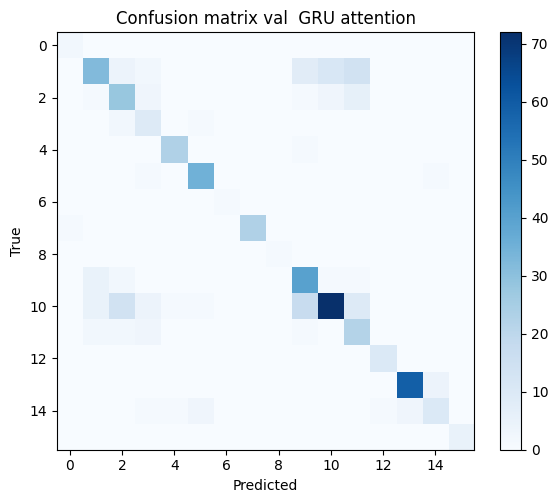

In [8]:
                                                                # validation metrics and confusion matrix with the best weightsmodel.load_state_dict(best_state)model.to(DEVICE).eval()# empty linewith torch.no_grad():    v_logits, v_targets = [], []                                # assign value to v_logits, v_targets    for xb, yb in dl_val:                                       # loop iteration        v_logits.append(model(xb.to(DEVICE)))        v_targets.append(yb.to(DEVICE))    v_logits = torch.cat(v_logits, 0)                           # assign value to v_logits    v_targets = torch.cat(v_targets, 0)                         # assign value to v_targets    vm = metrics_from_logits(v_logits, v_targets, num_classes)  # assign value to vm# empty lineprint("Val accuracy", vm["acc"])print("Val kappa", vm["kappa"])print("Val f1 macro", vm["f1"])# empty lineplt.figure(figsize=(6, 5))                                      # assign value to plt.figure(figsizeplt.imshow(vm["cm"], cmap="Blues")                              # assign value to plt.imshow(vm["cm"], cmapplt.title("Confusion matrix val  GRU attention")plt.xlabel("Predicted")plt.ylabel("True")plt.colorbar()plt.tight_layout()plt.savefig(FIGS / "rnn_gru_attn_confusion_val.png", dpi=150)   # assign value to plt.savefig(FIGS / "rnn_gru_attn_confusion_val.png", dpiplt.show()

Test accuracy 0.7278048780487805
Test kappa 0.6951110623056629
Test f1 macro 0.7752958462247979


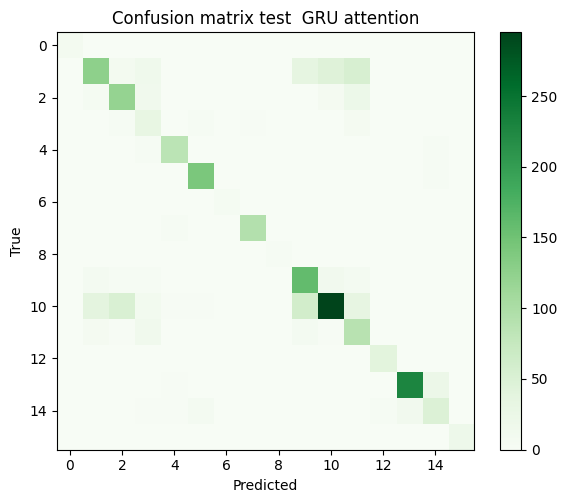


Classification report on test
              precision    recall  f1-score   support

     class_1     0.9000    1.0000    0.9474         9
     class_2     0.6961    0.4406    0.5396       286
     class_3     0.6349    0.7229    0.6761       166
     class_4     0.3370    0.6596    0.4460        47
     class_5     0.8947    0.8763    0.8854        97
     class_6     0.9097    0.9658    0.9369       146
     class_7     0.8333    1.0000    0.9091         5
     class_8     0.9588    0.9688    0.9637        96
     class_9     0.5714    1.0000    0.7273         4
    class_10     0.6038    0.8247    0.6972       194
    class_11     0.8217    0.6008    0.6941       491
    class_12     0.4190    0.7395    0.5350       119
    class_13     0.8889    0.9756    0.9302        41
    class_14     0.9461    0.9012    0.9231       253
    class_15     0.6154    0.6234    0.6194        77
    class_16     0.9500    1.0000    0.9744        19

    accuracy                         0.7278      

In [9]:
                                                                           # test metrics and per class reportwith torch.no_grad():    t_logits, t_targets = [], []                                           # assign value to t_logits, t_targets    for xb, yb in dl_test:                                                 # loop iteration        t_logits.append(model(xb.to(DEVICE)))        t_targets.append(yb.to(DEVICE))    t_logits = torch.cat(t_logits, 0)                                      # assign value to t_logits    t_targets = torch.cat(t_targets, 0)                                    # assign value to t_targets    tm = metrics_from_logits(t_logits, t_targets, num_classes)             # assign value to tm# empty lineprint("Test accuracy", tm["acc"])print("Test kappa", tm["kappa"])print("Test f1 macro", tm["f1"])# empty lineplt.figure(figsize=(6, 5))                                                 # assign value to plt.figure(figsizeplt.imshow(tm["cm"], cmap="Greens")                                        # assign value to plt.imshow(tm["cm"], cmapplt.title("Confusion matrix test  GRU attention")plt.xlabel("Predicted")plt.ylabel("True")plt.colorbar()plt.tight_layout()plt.savefig(FIGS / "rnn_gru_attn_confusion_test.png", dpi=150)             # assign value to plt.savefig(FIGS / "rnn_gru_attn_confusion_test.png", dpiplt.show()# empty linefrom sklearn.metrics import classification_report                          # import from sklearn.metricsnames = [f"class_{i}" for i in range(1, num_classes + 1)]                  # assign value to namesprint("\nClassification report on test")print(classification_report(t_targets.cpu().numpy(), t_logits.argmax(1).cpu().numpy(), target_names=names, digits=4, zero_division=0))  # print output message

In [10]:
from sklearn.metrics import (                                              # import from sklearn.metrics    accuracy_score,    cohen_kappa_score,    precision_recall_fscore_support,    classification_report,    confusion_matrix,)# empty line                                                                           # convert tensors to numpyy_true = t_targets.cpu().numpy()                                           # assign value to y_truey_pred = t_logits.argmax(1).cpu().numpy()                                  # assign value to y_pred# empty line                                                                           # global metricsoa = accuracy_score(y_true, y_pred)                                        # assign value to oakappa = cohen_kappa_score(y_true, y_pred)                                  # assign value to kappa# empty lineprec_macro, rec_macro, f1_macro, _ = precision_recall_fscore_support(      # assign value to prec_macro, rec_macro, f1_macro, _    y_true, y_pred, average="macro", zero_division=0                       # assign value to y_true, y_pred, average)prec_weighted, rec_weighted, f1_weighted, _ = precision_recall_fscore_support(  # assign value to prec_weighted, rec_weighted, f1_weighted, _    y_true, y_pred, average="weighted", zero_division=0                    # assign value to y_true, y_pred, average)# empty line                                                                           # per class metricsprec_class, rec_class, f1_class, support_class = precision_recall_fscore_support(  # assign value to prec_class, rec_class, f1_class, support_class    y_true, y_pred, average=None, zero_division=0                          # assign value to y_true, y_pred, average)# empty lineprint("Overall accuracy:", oa)print("Cohen kappa:", kappa)print("Macro precision:", prec_macro)print("Macro recall:", rec_macro)print("Macro f1:", f1_macro)print("Weighted precision:", prec_weighted)print("Weighted recall:", rec_weighted)print("Weighted f1:", f1_weighted)# empty lineprint("\nPer class metrics")for i, (p, r, f1, s) in enumerate(                                         # loop iteration    zip(prec_class, rec_class, f1_class, support_class), start=1           # assign value to zip(prec_class, rec_class, f1_class, support_class), start):    print(        f"Class {i:02d}: "        f"precision={p:.4f}, recall={r:.4f}, f1={f1:.4f}, support={s}"     # assign value to f"precision    )# empty lineprint("\nFull classification report")print(    classification_report(        y_true,        y_pred,        target_names=[f"class_{i}" for i in range(1, num_classes + 1)],    # assign value to target_names        digits=4,                                                          # assign value to digits        zero_division=0,                                                   # assign value to zero_division    ))

Overall accuracy: 0.7278048780487805
Cohen kappa: 0.6951110623056629
Macro precision: 0.7488017890735307
Macro recall: 0.8311901524936134
Macro f1: 0.7752958462247979
Weighted precision: 0.7601083732599877
Weighted recall: 0.7278048780487805
Weighted f1: 0.7298978704767799

Per class metrics
Class 01: precision=0.9000, recall=1.0000, f1=0.9474, support=9
Class 02: precision=0.6961, recall=0.4406, f1=0.5396, support=286
Class 03: precision=0.6349, recall=0.7229, f1=0.6761, support=166
Class 04: precision=0.3370, recall=0.6596, f1=0.4460, support=47
Class 05: precision=0.8947, recall=0.8763, f1=0.8854, support=97
Class 06: precision=0.9097, recall=0.9658, f1=0.9369, support=146
Class 07: precision=0.8333, recall=1.0000, f1=0.9091, support=5
Class 08: precision=0.9588, recall=0.9688, f1=0.9637, support=96
Class 09: precision=0.5714, recall=1.0000, f1=0.7273, support=4
Class 10: precision=0.6038, recall=0.8247, f1=0.6972, support=194
Class 11: precision=0.8217, recall=0.6008, f1=0.6941, su

In [11]:
                                                                          # combine train plus val for cross validationX_tv = np.concatenate([ds_train.X, ds_val.X], axis=0).astype(np.float32)  # N by By_tv = np.concatenate([ds_train.y, ds_val.y], axis=0).astype(np.int64)    # zero basedC_tv = int(y_tv.max()) + 1                                                # assign value to C_tvprint("TV set", X_tv.shape, "labels", y_tv.shape, "classes", C_tv)assert y_tv.min() >= 0 and y_tv.max() < C_tv                              # assign value to assert y_tv.min() >

TV set (8199, 200) labels (8199,) classes 16


In [12]:
                                                                           # train one fold on CPU to avoid any CUDA asserts from earlier cellsfrom sklearn.model_selection import StratifiedKFold                        # import from sklearn.model_selection# empty lineCV_DEVICE = torch.device("cpu")                                            # set computation device (GPU/CPU)torch.backends.cudnn.enabled = False                                       # assign value to torch.backends.cudnn.enabled# empty lineclass RNNFold(nn.Module):                                                  # define class RNNFold    def __init__(self, input_size, hidden_size, num_layers, C, p_drop=0.3):  # assign value to def __init__(self, input_size, hidden_size, num_layers, C, p_drop        super().__init__()        self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers,  # assign value to self.rnn                          nonlinearity="tanh", batch_first=True, bidirectional=False,  # assign value to nonlinearity                          dropout=p_drop if num_layers > 1 else 0.0)       # assign value to dropout        self.head = nn.Sequential(                                         # assign value to self.head            nn.Dropout(p_drop),            nn.Linear(hidden_size, 256),            nn.ReLU(inplace=True),                                         # assign value to nn.ReLU(inplace            nn.Dropout(p_drop),            nn.Linear(256, C),        )    def forward(self, x):                                                  # define function forward        out, _ = self.rnn(x)                                               # assign value to out, _        last = out[:, -1, :]                                               # assign value to last        return self.head(last)                                             # return value from function# empty linedef train_one_fold_rnn_cpu(X_tr, y_tr, X_va, y_va, hidden=128, layers=2, p_drop=0.3, epochs=80, patience=10):  # assign value to def train_one_fold_rnn_cpu(X_tr, y_tr, X_va, y_va, hidden    model_f = RNNFold(1, hidden, layers, C_tv, p_drop).to(CV_DEVICE)       # assign value to model_f    crit = nn.CrossEntropyLoss()                                           # assign value to crit    opt = optim.Adam(model_f.parameters(), lr=1e-3, weight_decay=1e-4)     # assign value to opt    sch = optim.lr_scheduler.ReduceLROnPlateau(opt, mode="min", factor=0.5, patience=3)  # assign value to sch# empty line    dl_tr = DataLoader(TensorDataset(torch.from_numpy(X_tr).unsqueeze(2), torch.from_numpy(y_tr)), batch_size=256, shuffle=True)  # assign value to dl_tr    dl_va = DataLoader(TensorDataset(torch.from_numpy(X_va).unsqueeze(2), torch.from_numpy(y_va)), batch_size=256, shuffle=False)  # assign value to dl_va# empty line    best_loss, best_state, bad = float("inf"), None, 0                     # assign value to best_loss, best_state, bad    for ep in range(1, epochs + 1):                                        # loop iteration        model_f.train()        for xb, yb in dl_tr:                                               # loop iteration            lg = model_f(xb.to(CV_DEVICE))                                 # assign value to lg            ls = crit(lg, yb.to(CV_DEVICE))                                # assign value to ls            opt.zero_grad(set_to_none=True)                                # assign value to opt.zero_grad(set_to_none            ls.backward()            opt.step()# empty line        model_f.eval()        with torch.no_grad():            v_sum, m = 0.0, 0                                              # assign value to v_sum, m            all_lg, all_y = [], []                                         # assign value to all_lg, all_y            for xb, yb in dl_va:                                           # loop iteration                lg = model_f(xb.to(CV_DEVICE))                             # assign value to lg                ls = crit(lg, yb.to(CV_DEVICE))                            # assign value to ls                v_sum += ls.item() * xb.size(0); m += xb.size(0)           # assign value to v_sum +                all_lg.append(lg); all_y.append(yb)            v_loss = v_sum / max(1, m)                                     # assign value to v_loss        sch.step(v_loss)# empty line        if v_loss < best_loss:                                             # conditional statement            best_loss = v_loss                                             # assign value to best_loss            best_state = {k: v.cpu().clone() for k, v in model_f.state_dict().items()}  # assign value to best_state            bad = 0                                                        # assign value to bad        else:                                                              # conditional statement            bad += 1                                                       # assign value to bad +            if bad >= patience:                                            # assign value to if bad >                break# empty line    model_f.load_state_dict(best_state)    model_f.eval()    with torch.no_grad():        all_lg, all_y = [], []                                             # assign value to all_lg, all_y        for xb, yb in dl_va:                                               # loop iteration            all_lg.append(model_f(xb.to(CV_DEVICE)))            all_y.append(yb.to(CV_DEVICE))        lg = torch.cat(all_lg, 0)                                          # assign value to lg        tg = torch.cat(all_y, 0)                                           # assign value to tg    preds = lg.argmax(1).cpu().numpy()                                     # assign value to preds    true = tg.cpu().numpy()                                                # assign value to true    acc = accuracy_score(true, preds)                                      # assign value to acc    prec, rec, f1, _ = precision_recall_fscore_support(true, preds, labels=np.arange(C_tv), average="macro", zero_division=0)  # assign value to prec, rec, f1, _    kap = cohen_kappa_score(true, preds)                                   # assign value to kap    return acc, f1, kap                                                    # return value from function

In [12]:
                                                                           # run five fold cross validation and print mean and stdskf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)           # assign value to skfaccs, f1s, kaps = [], [], []                                               # assign value to accs, f1s, kapsfor fold, (i_tr, i_va) in enumerate(skf.split(X_tv, y_tv), 1):             # loop iteration    X_tr, y_tr = X_tv[i_tr], y_tv[i_tr]                                    # assign value to X_tr, y_tr    X_va, y_va = X_tv[i_va], y_tv[i_va]                                    # assign value to X_va, y_va    acc, f1, kap = train_one_fold_rnn_cpu(X_tr, y_tr, X_va, y_va, hidden=128, layers=2, p_drop=0.3)  # assign value to acc, f1, kap    print(f"Fold {fold}  acc {acc:.4f}  f1 {f1:.4f}  kappa {kap:.4f}")    accs.append(acc); f1s.append(f1); kaps.append(kap)# empty lineprint("\nCV mean acc", np.mean(accs).round(4), "std", np.std(accs).round(4))print("CV mean f1", np.mean(f1s).round(4), "std", np.std(f1s).round(4))print("CV mean kappa", np.mean(kaps).round(4), "std", np.std(kaps).round(4))

Fold 1  acc 0.4970  f1 0.3104  kappa 0.4022
Fold 2  acc 0.5183  f1 0.2938  kappa 0.4310
Fold 3  acc 0.4659  f1 0.2173  kappa 0.3550
Fold 4  acc 0.5000  f1 0.2842  kappa 0.3992
Fold 5  acc 0.4674  f1 0.1969  kappa 0.3506

CV mean acc 0.4897 std 0.0202
CV mean f1 0.2605 std 0.0449
CV mean kappa 0.3876 std 0.0305
